In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import astropy.coordinates as coord
from astropy.table import Table
from astropy.io import fits
import astropy.units as u
import gala.coordinates as gc
import h5py

In [2]:
plt.style.use('notebook')

In [3]:
t = Table.read('../data/combined_params_1d.fits')
ind_sort = np.argsort(t['phi1'])
t = t[ind_sort]

In [4]:
# read in models
files = []
names = ['reg_orb.hdf5', 'chaotic_orb.hdf5', 'BarModels_RL1_Mb5e+09_Om38.0.hdf5',
         'BarModels_RL1_Mb1e+10_Om45.0.hdf5']
cpmod = []

mod_names = ['regular', 'chaotic', 'bar_slow', 'bar_fast']
tbls = []

for e, name in enumerate(names):
    f = h5py.File('../data/{:s}'.format(name), 'r')
    files += [f]
    cgal = coord.Galactocentric(x=f['pos'][0]*u.kpc, y=f['pos'][1]*u.kpc, z=f['pos'][2]*u.kpc)
    cp = cgal.transform_to(gc.Pal5PriceWhelan18)
    cpmod += [cp]
    
    tin = Table.read('../data/combined_params_1d_{:s}.fits'.format(mod_names[e]))
    ind_sort = np.argsort(tin['phi1'])
    tin = tin[ind_sort]
    tbls += [tin]

In [14]:
row_labels = ['$\phi_2$ [deg]', '$\phi_2$ [deg]', '$\Delta\phi_2$ [deg]', '$\\tilde{N}$', '$\sigma$ [deg]']
col_labels = ['Regular', 'Chaotic', 'Light bar', 'Massive bar']

In [15]:
# normalize total number of counts where the data is
phimin, phimax = np.min(t['phi1']), np.max(t['phi1'])
norm = np.ones(len(names))
Ndata = np.sum(t['n'])

for i in range(len(names)):
    ind = (tbls[i]['phi1']>=phimin) & (tbls[i]['phi1']<=phimax)
    norm[i] = Ndata / np.sum(tbls[i]['n'][ind])

In [16]:
# parabola along Pal5
p = [0.018,0.14,-0.7]
p = [0.018,0.14,0]
poly_track_coarse = np.poly1d(p)

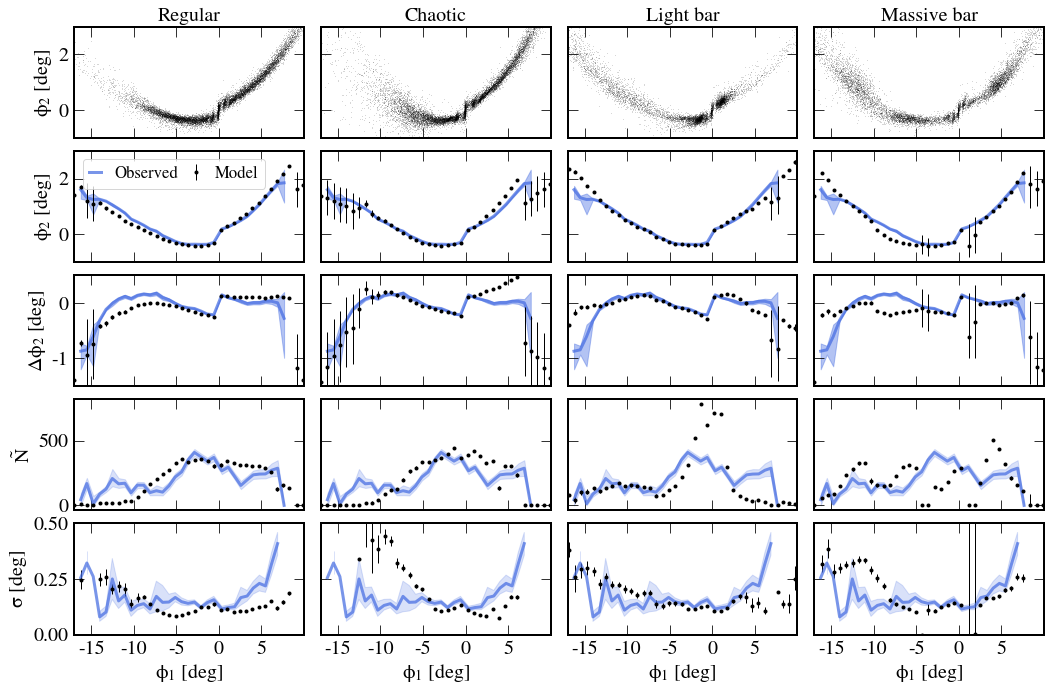

In [29]:
fig, ax = plt.subplots(5,4,figsize=(15,10), sharex='col', sharey='row')

for i in range(4):
    plt.sca(ax[1][i])
    plt.plot(t['phi1'], t['phi2'], '-', color='royalblue', lw=3, alpha=0.7, zorder=1, label='Observed')
    plt.fill_between(t['phi1'], t['phi2'] + t['phi2_ep'], t['phi2'] - t['phi2_em'], color='royalblue', alpha=0.4,
                    label='')
    plt.errorbar(tbls[i]['phi1'], tbls[i]['phi2']-0.4, yerr=(tbls[i]['phi2_em'], tbls[i]['phi2_ep']),
                 fmt='o', color='k', ms=4, mew=0, lw=1, label='Model')
    plt.ylim(-1,3)
    
    plt.sca(ax[2][i])
    plt.plot(t['phi1'], t['phi2'] - poly_track_coarse(t['phi1']),
             '-', color='royalblue', lw=3, alpha=0.7, zorder=1)
    plt.fill_between(t['phi1'], t['phi2'] + t['phi2_ep'] - poly_track_coarse(t['phi1']),
                     t['phi2'] - t['phi2_em'] - poly_track_coarse(t['phi1']), color='royalblue', alpha=0.4, label='')
    plt.errorbar(tbls[i]['phi1'], tbls[i]['phi2']-0.4 - poly_track_coarse(tbls[i]['phi1']),
                 yerr=(tbls[i]['phi2_em'], tbls[i]['phi2_ep']), fmt='o', color='k', ms=4, mew=0, lw=1, label='Model')
    plt.ylim(-1.5,0.5)

    plt.sca(ax[3][i])
    plt.plot(t['phi1'], t['n'], '-', color='royalblue', lw=3, alpha=0.7)
    plt.fill_between(t['phi1'], t['n'] + t['n_ep'], t['n'] - t['n_em'], color='royalblue', alpha=0.2)
    plt.errorbar(tbls[i]['phi1'], norm[i]*tbls[i]['n'], yerr=(norm[i]*tbls[i]['n_em'], norm[i]*tbls[i]['n_ep']),
                 fmt='o', color='k', ms=4, mew=0, lw=1)
    
    plt.sca(ax[4][i])
    plt.plot(t['phi1'], t['w'], '-', color='royalblue', lw=3, alpha=0.7)
    plt.fill_between(t['phi1'], t['w'] + t['w_ep'], t['w'] - t['w_em'], color='royalblue', alpha=0.2)
    plt.errorbar(tbls[i]['phi1'], tbls[i]['w'], yerr=(tbls[i]['w_em'], tbls[i]['w_ep']),
                 fmt='o', color='k', ms=4, mew=0, lw=1)
    plt.xlabel('$\phi_1$ [deg]')
    plt.gca().set_xticks([-15,-10,-5,0,5])
    plt.ylim(0,0.5)

    plt.sca(ax[0][i])
    plt.plot(cpmod[i].phi1, cpmod[i].phi2-0.4*u.deg, 'k.', ms=2, mec='none', alpha=0.2, rasterized=True)
    plt.xlim(-17,10)
    plt.ylim(-1,3)
    plt.title(col_labels[i], fontsize='medium')
#     plt.errorbar(tbls[i]['phi1'], tbls[i]['phi2']-0.4, yerr=(tbls[i]['phi2_em'], tbls[i]['phi2_ep']),
#                  fmt='o', color='r', ms=4, mew=0, lw=1)

for i in range(5):    
    plt.sca(ax[i][0])
    plt.ylabel(row_labels[i])

plt.sca(ax[1][0])
plt.legend(loc=2, fontsize='small', ncol=2, handlelength=0.7, columnspacing=0.7)
    
plt.tight_layout(h_pad=0, w_pad=0.4)
plt.savefig('../plots/model_comparison.png', dpi=200)
plt.savefig('../paper/model_comparison.pdf', dpi=200)